In [1]:
import pandas as pd
import json
import numpy as np
from tqdm import tqdm
import requests
import traceback
import gcsfs
import fsspec

from kloppy import skillcorner

In [2]:
fs = gcsfs.GCSFileSystem(token="google_default")

/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [5]:
BUCKET_NAME = "arthur_tmp"
BASE_GCS_PATH = f"gs://{BUCKET_NAME}/analytics_cup"
PROCESSED_DIR = f"{BASE_GCS_PATH}/processed"
PITCH_CONTROL_DIR = f"{BASE_GCS_PATH}/pitch_control_center_forward_low_block"
CLUSTERING_DIR = f"{BASE_GCS_PATH}/clustering"

X_MIN, X_MAX = -52, 52
Y_MIN, Y_MAX = -34, 34
PITCH_LENGTH, PITCH_WIDTH = 105.0, 68.0

params = {
    'v_max': 5.0,
    'a_max': 7.0,
    'reaction_time': 0.7,
    'lambda_param': 3.0,
    'time_max': 6.0,
    'dt': 0.02
}

In [4]:
def read_parquet_gcs(fs: gcsfs.GCSFileSystem, gcs_path: str) -> pd.DataFrame:
    if not fs.exists(gcs_path):
        raise FileNotFoundError(gcs_path)
    # open as file-like and let pandas/pyarrow read
    with fs.open(gcs_path, "rb") as f:
        return pd.read_parquet(f)
    
def write_parquet_gcs(df: pd.DataFrame, gcs_path: str):
    # rely on pandas+fsspec to write directly
    # storage_options may be required depending on environment (GCE default works)
    df.to_parquet(gcs_path, index=False)

# DATA PREP

In [74]:
def load_tracking_full_from_kloppy(
    match_id: int,
    sort_rows: bool = False,
    require_ball_detected: bool = True,
) -> pd.DataFrame:

    dataset = skillcorner.load_open_data(
        match_id=match_id,
        coordinates="skillcorner",
    )

    rows = []

    for frame in dataset.frames:
        frame_id = frame.frame_id
        ts = frame.timestamp
        period = frame.period.id if frame.period is not None else None

        # --- Players ---
        for player, coords in frame.players_coordinates.items():
            is_detected = coords is not None

            rows.append({
                "match_id": match_id,
                "time": ts,
                "frame": frame_id,
                "period": period,
                "player_id": player.player_id,
                "is_detected": is_detected,
                "is_ball": False,
                "x": coords.x if is_detected else np.nan,
                "y": coords.y if is_detected else np.nan,
            })

        # --- Ball ---
        ball_coords = frame.ball_coordinates
        ball_detected = ball_coords is not None

        if (not require_ball_detected) or ball_detected:
            rows.append({
                "match_id": match_id,
                "time": ts,
                "frame": frame_id,
                "period": period,
                "player_id": -1,
                "is_detected": ball_detected,
                "is_ball": True,
                "x": ball_coords.x if ball_detected else np.nan,
                "y": ball_coords.y if ball_detected else np.nan,
            })

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    # --- Types ---
    df["is_ball"] = df["is_ball"].astype(bool)
    df["is_detected"] = df["is_detected"].astype(bool)
    df["frame"] = df["frame"].astype(int)
    df["player_id"] = df["player_id"].astype(int)

    # --- Rescaling ---
    den_x, den_y = (X_MAX - X_MIN), (Y_MAX - Y_MIN)
    valid_xy = df[["x", "y"]].notna().all(axis=1)

    df["x_rescaled"] = np.where(
        valid_xy,
        (df["x"] - X_MIN) / den_x * PITCH_LENGTH,
        np.nan
    )
    df["y_rescaled"] = np.where(
        valid_xy,
        (df["y"] - Y_MIN) / den_y * PITCH_WIDTH,
        np.nan
    )

    # --- Sorting ---
    if sort_rows:
        df = df.sort_values(["frame", "is_ball", "player_id"]).reset_index(drop=True)
    else:
        df = df.sort_values(["frame"]).reset_index(drop=True)

    print(
        f"[match {match_id}] rows: {len(df)}, "
        f"players: {(~df['is_ball']).sum()}, "
        f"ball: {df['is_ball'].sum()}"
    )

    return df

In [70]:
df = load_tracking_full_from_kloppy(match_id=1886347)

[match 1886347] rows: 724617, players: 693106, ball: 31511


In [71]:
df.head()

,match_id,time,frame,period,player_id,is_detected,is_ball,x,y,x_rescaled,y_rescaled
0,1886347,0 days 00:00:01.800000,28,1,51009,True,False,-40.71,-0.27,11.398558,33.73
1,1886347,0 days 00:00:01.800000,28,1,-1,True,True,0.03,-0.36,52.530288,33.64
2,1886347,0 days 00:00:01.800000,28,1,38673,True,False,1.76,9.23,54.276923,43.23
3,1886347,0 days 00:00:01.800000,28,1,50951,True,False,-0.07,-8.13,52.429327,25.87
4,1886347,0 days 00:00:01.800000,28,1,965685,True,False,7.63,-17.23,60.203365,16.77


In [75]:
def load_meta_mapping_from_kloppy(match_id: int) -> pd.DataFrame:
    dataset = skillcorner.load_open_data(
        match_id=match_id,
        coordinates="skillcorner",
    )

    teams = dataset.metadata.teams  # home_team, away_team
    if len(teams) != 2:
        return pd.DataFrame()

    home_team, away_team = teams

    rows = []

    for team, team_type in [(home_team, "home"), (away_team, "away")]:
        for player in team.players:
            rows.append({
                "match_id": match_id,
                "player_id": player.player_id,  # ou player.jersey_no
                "team_id": team.team_id,
                "team_name": team.name,
                #"team_short": team.short_name,
                "player_short_name": player.name,  # ou player.short_name
                "player_role": getattr(player, "position", None).name if getattr(player, "position", None) else None,
                "position_group": getattr(player, "position", None).position_group if getattr(player, "position", None) else None,
                "home_team_id": home_team.team_id,
                "away_team_id": away_team.team_id,
            })

    return pd.DataFrame(rows)

In [76]:
def load_meta_from_github(match_id: int) -> pd.DataFrame:
    """
    Charge le fichier meta SkillCorner depuis GitHub et le transforme
    dans le même format que load_meta_mapping (ton ancien loader).
    """

    url = (
        "https://raw.githubusercontent.com/SkillCorner/opendata/master/"
        f"data/matches/{match_id}/{match_id}_match.json"
    )

    r = requests.get(url)
    if r.status_code != 200:
        # Pas de fichier trouvé
        return pd.DataFrame()

    meta = r.json()
    if not meta:
        return pd.DataFrame()

    # On récupère les infos d'équipe
    home_team = meta.get("home_team", {}) or {}
    away_team = meta.get("away_team", {}) or {}

    rows = []
    for p in meta.get("players", []):
        # Si pas d'id, on skip
        if "id" not in p:
            continue

        team_id = p.get("team_id")
        team = home_team if team_id == home_team.get("id") else away_team

        rows.append({
            "match_id": meta.get("id"),
            "player_id": p.get("id"),
            "team_id": team_id,
            "team_name": team.get("name"),
            "team_short": team.get("short_name"),
            "player_short_name": p.get("short_name"),
            "player_role": p.get("player_role", {}).get("name"),
            "position_group": p.get("player_role", {}).get("position_group"),
            "home_team_id": home_team.get("id"),
            "away_team_id": away_team.get("id"),
        })

    return pd.DataFrame(rows)

In [42]:
df_meta = load_meta_from_github(match_id=1886347)

In [62]:
df_meta

,match_id,player_id,team_id,team_name,team_short,player_short_name,player_role,position_group,home_team_id,away_team_id
0,1886347,38673,4177,Auckland FC,Auckland FC,G. May,Center Forward,Center Forward,4177,1805
1,1886347,51713,4177,Auckland FC,Auckland FC,C. Elliott,Right Back,Full Back,4177,1805
2,1886347,50951,4177,Auckland FC,Auckland FC,J. Brimmer,Center Forward,Center Forward,4177,1805
3,1886347,50978,1805,Newcastle United Jets FC,Newcastle,C. Timmins,Left Defensive Midfield,Midfield,4177,1805
4,1886347,133498,4177,Auckland FC,Auckland FC,F. De Vries,Left Back,Full Back,4177,1805
5,1886347,33697,4177,Auckland FC,Auckland FC,N. Pijnaker,Left Center Back,Central Defender,4177,1805
6,1886347,51667,4177,Auckland FC,Auckland FC,D. Hall,Right Center Back,Central Defender,4177,1805
7,1886347,14736,4177,Auckland FC,Auckland FC,L. Verstraete,Defensive Midfield,Midfield,4177,1805
8,1886347,966125,1805,Newcastle United Jets FC,Newcastle,W. Will Dobson,Substitute,Other,4177,1805
9,1886347,966124,1805,Newcastle United Jets FC,Newcastle,N. James,Substitute,Other,4177,1805


In [77]:
def load_events_basic_from_github(match_id: int) -> pd.DataFrame:
    url = (
        "https://raw.githubusercontent.com/SkillCorner/opendata/master/"
        f"data/matches/{match_id}/{match_id}_dynamic_events.csv"
    )

    df = pd.read_csv(url)

    # --- même logique que ton code existant ---
    if "event_type" not in df.columns or "end_type" not in df.columns:
        return pd.DataFrame()

    #df = df.query(
    #    "event_type == 'player_possession' and end_type == 'pass'"
    #).copy()

    if df.empty:
        return pd.DataFrame()

    df["player_in_possession_id"] = df["player_id"]

    # rescale SkillCorner -> 105x68
    X_MIN, X_MAX = -52, 52
    Y_MIN, Y_MAX = -34, 34

    if {"x_start", "y_start", "x_end", "y_end"}.issubset(df.columns):
        df["x_start_rescaled"] = (df["x_start"] - X_MIN) / (X_MAX - X_MIN) * 105.0
        df["y_start_rescaled"] = (df["y_start"] - Y_MIN) / (Y_MAX - Y_MIN) * 68.0
        df["x_end_rescaled"]   = (df["x_end"]   - X_MIN) / (X_MAX - X_MIN) * 105.0
        df["y_end_rescaled"]   = (df["y_end"]   - Y_MIN) / (Y_MAX - Y_MIN) * 68.0

    df = df.loc[:, df.notna().any(axis=0)]

    if "frame_start" in df.columns:
        df = df.sort_values("frame_start").reset_index(drop=True)

    return df

In [47]:
df_events = load_events_basic_from_github(match_id=1886347)

In [48]:
df_events

,event_id,index,match_id,frame_start,frame_end,frame_physical_start,time_start,time_end,minute_start,second_start,...,xshot_player_possession_max,is_player_possession_start_matched,is_player_possession_end_matched,is_previous_pass_matched,is_pass_reception_matched,fully_extrapolated,x_start_rescaled,y_start_rescaled,x_end_rescaled,y_end_rescaled
0,8_0,0,1886347,28,28,NaN,00:01.8,00:01.8,0,1,...,NaN,True,True,NaN,True,False,53.237019,34.49,53.237019,34.49
1,8_1,1,1886347,48,58,NaN,00:03.8,00:04.8,0,3,...,NaN,True,True,True,True,False,29.975481,35.22,30.076442,36.70
2,7_0,2,1886347,48,53,NaN,00:03.8,00:04.3,0,3,...,NaN,True,True,NaN,NaN,False,41.929327,31.22,41.030769,32.62
3,7_1,3,1886347,48,58,NaN,00:03.8,00:04.8,0,3,...,NaN,True,True,NaN,True,False,31.611058,50.66,31.944231,51.69
4,9_0,4,1886347,56,58,34.0,00:02.4,00:04.8,0,2,...,NaN,True,True,True,True,NaN,65.655288,34.06,66.614423,33.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5074,7_2541,5074,1886347,58757,58761,NaN,96:35.7,96:36.1,96,35,...,NaN,True,True,NaN,NaN,False,84.050481,42.32,84.191827,43.17
5075,9_936,5075,1886347,58760,58761,58760.0,96:36.0,96:36.1,96,36,...,0.402,True,True,True,NaN,NaN,30.561058,30.32,30.520673,30.26
5076,7_2542,5077,1886347,58907,58932,NaN,96:50.7,96:53.2,96,50,...,NaN,True,True,NaN,NaN,True,50.904808,7.32,52.005288,4.07
5077,8_998,5076,1886347,58907,58932,NaN,96:50.7,96:53.2,96,50,...,NaN,True,True,NaN,NaN,False,11.751923,21.77,14.407212,15.52


In [106]:
df_events.event_type.value_counts()

event_type
passing_option        2544
player_possession      999
on_ball_engagement     937
off_ball_run           599
Name: count, dtype: int64

In [107]:
df_events.end_type.value_counts()

end_type
pass                   902
indirect_regain        120
possession_loss         48
indirect_disruption     44
direct_regain           24
shot                    23
direct_disruption       18
foul_suffered           15
foul_committed          13
clearance                9
unknown                  2
Name: count, dtype: int64

In [49]:
df_events.team_out_of_possession_phase_type.value_counts()

team_out_of_possession_phase_type
medium_block             2112
low_block                1250
high_block                795
chaotic                   409
defending_set_play        225
defending_direct          136
defending_transition       59
defending_quick_break      47
disruption                 46
Name: count, dtype: int64

In [50]:
df_events.team_in_possession_phase_type.value_counts()

team_in_possession_phase_type
create         2112
finish         1250
build_up        795
chaotic         409
set_play        225
direct          136
transition       59
quick_break      47
disruption       46
Name: count, dtype: int64

In [78]:
def to_seconds(series: pd.Series) -> pd.Series:
    """
    Convert time to seconds.
    Handles strings like 'HH:MM:SS.ff' (e.g., '00:00:00.10'),
    numeric seconds, and large integers/floats in ms.
    Returns a float Series.
    """
    # if already numeric-ish, start there
    s_num = pd.to_numeric(series, errors="coerce")

    # try timedelta parsing for strings like HH:MM:SS.ff
    s_td = pd.to_timedelta(series.astype(str).str.strip().str.replace(",", ".", regex=False),
                           errors="coerce")
    s_sec_td = s_td.dt.total_seconds()

    # prefer timedelta parse when available, else numeric
    s = s_sec_td.fillna(s_num)

    # if values look like milliseconds (very large), convert to seconds
    if s.notna().any():
        median_val = s.dropna().median()
        # heuristic: median > 1e6 suggests ms ticks (e.g., 1,650,000,000)
        if median_val is not None and median_val > 1e6:
            s = s / 1000.0

    return s.astype(float)

In [79]:
def estimate_fps_from_time_df(df: pd.DataFrame, group_cols=("match_id",)) -> float:
    """
    Estimate frames-per-second from median time delta.
    Works even if you pass only ball rows or all rows.
    """
    t = to_seconds(df["time"])
    # compute dt within each group (match)
    if not isinstance(group_cols, (list, tuple)):
        group_cols = (group_cols,)
    dt = t.groupby([df[c] for c in group_cols]).diff().astype(float)
    dt = dt[(dt > 0) & dt.notna()]
    if dt.empty:
        return 25.0
    fps = 1.0 / float(dt.median())
    return float(np.clip(fps, 5, 120))

In [80]:
def compute_all_velocities(
    tr_df: pd.DataFrame,
    fps_fallback: float = 10.0,
    interp_gap_s: float = 0.40,
    smooth_window_s: float = 0.70,
    clip_speed_player: float = 7.0,   # tighter and realistic
    clip_speed_ball: float = 35.0,    # typical max shot
) -> pd.DataFrame:
    """
    Compute velocities (vx_mps, vy_mps, speed_mps) for all entities (players + ball),
    with physical clipping and gap-safe smoothing.
    """

    df = tr_df.copy()
    df["time_s"] = to_seconds(df["time"])
    df = df.sort_values(["match_id", "is_ball", "player_id", "frame"]).reset_index(drop=True)

    results = []

    for (match_id, is_ball, pid), g in df.groupby(["match_id", "is_ball", "player_id"], sort=False):
        g = g.sort_values("frame").copy()
        if len(g) < 3:
            continue

        # Convert coords
        x = pd.to_numeric(g["x_rescaled"], errors="coerce")
        y = pd.to_numeric(g["y_rescaled"], errors="coerce")
        t = pd.to_numeric(g["time_s"], errors="coerce")

        # fallback if missing time
        if t.isna().any():
            dt_nominal = 1.0 / fps_fallback
            t = np.arange(len(x)) * dt_nominal

        dt = t.diff()
        dt_mean = np.nanmedian(dt)
        dt[dt <= 0] = dt_mean  # fix zero or negative steps

        # remove unrealistic time jumps
        mask_big_jump = dt > 3 * dt_mean
        if mask_big_jump.any():
            x[mask_big_jump] = np.nan
            y[mask_big_jump] = np.nan

        # interpolate + smooth
        x_i = x.interpolate(limit_direction="both", limit=3)
        y_i = y.interpolate(limit_direction="both", limit=3)
        window_frames = int(round(smooth_window_s / (dt_mean or (1.0 / fps_fallback))))
        if window_frames % 2 == 0:
            window_frames += 1
        x_s = x_i.rolling(window_frames, center=True, min_periods=1).median()
        y_s = y_i.rolling(window_frames, center=True, min_periods=1).median()

        # compute velocities
        vx = x_s.diff() / dt
        vy = y_s.diff() / dt

        # smooth velocity slightly
        vx = vx.rolling(3, center=True, min_periods=1).mean()
        vy = vy.rolling(3, center=True, min_periods=1).mean()

        # clip velocities physically
        vmax = clip_speed_ball if is_ball else clip_speed_player
        vx = vx.clip(lower=-vmax, upper=vmax)
        vy = vy.clip(lower=-vmax, upper=vmax)
        speed = np.sqrt(vx**2 + vy**2)

        g["vx_mps"] = vx
        g["vy_mps"] = vy
        g["speed_mps"] = speed
        results.append(g)

    df_vel = pd.concat(results, ignore_index=True)
    return df_vel


In [81]:
def merge_tracking_and_events(match_id: int, df_events: pd.DataFrame, df_tracking: pd.DataFrame) -> pd.DataFrame:
    """
    Merge tracking data with event info so each pass start frame inherits:
      - team_in_possession
      - attacking_side
      - player_in_possession_id
      - pass outcome + coordinates (rescaled)
      - labels such as lead_to_goal if present
    
    Only uses the *start frame* of each pass event, since SoccerMap learns from
    the player/ball configuration before the pass.
    """
    frames_all = []

    # ✅ Keep only pass possessions (successful / unsuccessful)
    df_events_pass = df_events.query(
        "event_type == 'player_possession'" #and end_type == 'pass'"
    ).copy()

    if df_events_pass.empty:
        print(f"⚠️ No valid pass events for match {match_id}")
        return pd.DataFrame()

    for _, ev in tqdm(df_events_pass.iterrows(), total=len(df_events_pass), desc=f"Merging match {match_id}"):
        frame_start = int(ev["frame_start"]) if "frame_start" in ev else None
        if frame_start is None or frame_start not in df_tracking["frame"].values:
            continue

        # take only the frame at the start of the pass
        tr_slice = df_tracking.loc[df_tracking["frame"] == frame_start].copy()
        if tr_slice.empty:
            continue

        # Assign event info (broadcast to all players + ball in that frame)
        tr_slice["event_id"] = ev.get("event_id")
        tr_slice["event_type"] = ev.get("event_type")
        tr_slice["end_type"] = ev.get("end_type")
        tr_slice["pass_outcome"] = ev.get("pass_outcome", None)
        tr_slice["team_in_possession_phase_type"] = ev.get("team_in_possession_phase_type", None)
        tr_slice["team_out_of_possession_phase_type"] = ev.get("team_out_of_possession_phase_type", None)
        tr_slice["player_in_possession_id"] = ev.get("player_in_possession_id", ev.get("player_id", None))
        tr_slice["team_in_possession"] = ev.get("team_id")
        tr_slice["team_in_possession_shortname"] = ev.get("team_shortname")
        tr_slice["attacking_side"] = ev.get("attacking_side")
        tr_slice["period"] = ev.get("period")

        # --- Pass start and end coordinates ---
        for c in ["x_start_rescaled", "y_start_rescaled", "x_end_rescaled", "y_end_rescaled"]:
            if c in ev:
                tr_slice[c] = ev[c]

        # --- Add label columns if available (e.g. for model training) ---
        for label_col in ["lead_to_goal", "lead_to_shot", "lead_to_box_entry"]:
            if label_col in ev:
                tr_slice[label_col] = ev[label_col]

        frames_all.append(tr_slice)

    if not frames_all:
        print(f"⚠️ No matching frames for match {match_id}")
        return pd.DataFrame()

    df_merged = pd.concat(frames_all, ignore_index=True)

    # --- Clean up ---
    df_merged["match_id"] = match_id
    df_merged = df_merged.sort_values(["period", "frame"]).reset_index(drop=True)

    #print(f"✅ [match {match_id}] merged frames: {len(df_merged):,}")
    return df_merged

In [82]:
def normalize_tracking_direction(df_merged: pd.DataFrame) -> pd.DataFrame:
    """
    Flip coordinates so that team_in_possession always attacks left -> right.
    """
    df_norm = df_merged.copy()

    mask = df_norm["attacking_side"] == "right_to_left"
    df_norm.loc[mask, "x_rescaled"] = 105.0 - df_norm.loc[mask, "x_rescaled"]
    df_norm.loc[mask, "y_rescaled"] = 68.0 - df_norm.loc[mask, "y_rescaled"]
    df_norm.loc[mask, "vx_mps"] = -df_norm.loc[mask, "vx_mps"]
    df_norm.loc[mask, "vy_mps"] = -df_norm.loc[mask, "vy_mps"]

    return df_norm

In [95]:
def process_data(match_id: int, save_to_gcs=False) -> int:
    try:
        if save_to_gcs:
            outpath = f"{PROCESSED_DIR}/{match_id}.parquet"
            if fs.exists(outpath):
                print(f"{match_id} already processed")
                return match_id

        # 1) load base data
        tr = load_tracking_full_from_kloppy(match_id)
        ev = load_events_basic_from_github(match_id)
        meta = load_meta_from_github(match_id)

        if tr is None or ev is None or meta is None or tr.empty or ev.empty or meta.empty:
            # skip if any missing
            # print(f"⚠️ Skipped {match_id} (missing one of: tracking, events, meta)")
            return match_id

        # 2) compute velocities (user function)
        tr = compute_all_velocities(tr)

        # 3) add meta
        tr = tr.merge(meta, on=["match_id", "player_id"], how="left", validate="m:1")
        tr.loc[tr["is_ball"], ["team_id", "team_name", "team_short"]] = np.nan

        # 4) merge with events
        df_merged = merge_tracking_and_events(match_id, ev, tr)

        # 5) normalize direction
        df_normed = normalize_tracking_direction(df_merged)

        # 6) sanity & write
        if df_normed[["x_rescaled", "y_rescaled"]].isna().all().any():
            raise ValueError("Missing rescaled coordinates after normalization.")
        df_normed = df_normed.dropna(subset=['x_rescaled', 'y_rescaled'])
        
        # 7) write to GCS
        write_parquet_gcs(df_normed, outpath)
        
        return match_id

    except Exception as e:
        # log error but don't crash the pool
        print(f"❌ Error processing {match_id}: {e}")
        traceback.print_exc()
        return match_id

In [118]:
%%time

process_data(match_id=1886347, save_to_gcs=True)

[match 1886347] rows: 724617, players: 693106, ball: 31511


Merging match 1886347: 100%|██████████| 999/999 [00:07<00:00, 127.71it/s]


CPU times: user 32.6 s, sys: 286 ms, total: 32.9 s
Wall time: 37.1 s


In [84]:
%%time

match_ids = [1886347, 1899585, 1925299, 1953632, 1996435, 2006229, 2011166, 2013725, 2015213, 2017461]

for match_id in tqdm(match_ids, total=len(match_ids)):
    process_data(match_id=match_id, save_to_gcs=True)

 10%|█         | 1/10 [00:00<00:01,  5.53it/s]

1886347 already processed
[match 1899585] rows: 663170, players: 634338, ball: 28832


/var/tmp/ipykernel_21172/2598728654.py:7: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)

 20%|██        | 2/10 [00:35<02:47, 20.88s/it]

[match 1925299] rows: 806107, players: 771049, ball: 35058



 30%|███       | 3/10 [01:17<03:32, 30.35s/it]

[match 1953632] rows: 746548, players: 714087, ball: 32461



 40%|████      | 4/10 [01:53<03:16, 32.82s/it]

[match 1996435] rows: 734608, players: 702665, ball: 31943



 50%|█████     | 5/10 [02:32<02:55, 35.10s/it]

[match 2006229] rows: 732849, players: 700981, ball: 31868



 60%|██████    | 6/10 [03:09<02:22, 35.61s/it]

[match 2011166] rows: 625018, players: 597838, ball: 27180



 70%|███████   | 7/10 [03:40<01:41, 33.97s/it]

[match 2013725] rows: 710491, players: 679596, ball: 30895



 80%|████████  | 8/10 [04:19<01:11, 35.75s/it]

[match 2015213] rows: 708668, players: 677855, ball: 30813



 90%|█████████ | 9/10 [04:56<00:35, 35.97s/it]

[match 2017461] rows: 642482, players: 614542, ball: 27940


/var/tmp/ipykernel_21172/2598728654.py:7: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)

100%|██████████| 10/10 [05:31<00:00, 33.11s/it]

CPU times: user 4min 31s, sys: 6.21 s, total: 4min 38s
Wall time: 5min 31s


In [5]:
match_id=1886347
df_normed = read_parquet_gcs(fs, gcs_path=f"{PROCESSED_DIR}/{match_id}.parquet")

# PITCH CONTROL

In [5]:
def get_player_id_position(tracking_df, player_position: str) -> dict:
    """
    Retourne les IDs des joueurs occupant une position donnée pour chaque équipe.
    Si aucun joueur n'est trouvé pour une équipe, la valeur correspondante est None.
    """
    home_team_id = tracking_df["home_team_id"].iloc[0]
    away_team_id = tracking_df["away_team_id"].iloc[0]

    def get_player_id(team_id):
        filtered = tracking_df[
            (tracking_df["position_group"] == player_position)
            & (tracking_df["team_id"] == team_id)
        ]
        return filtered["player_id"].iloc[0] if not filtered.empty else None

    return {
        home_team_id: get_player_id(home_team_id),
        away_team_id: get_player_id(away_team_id),
    }

In [23]:
player_id_position_dict = get_player_id_position(df_normed, "Center Forward")
player_id_position_dict

{4177.0: 38673, 1805.0: 966120}

In [6]:
def build_team_tracking(df, team_side='home'):
    """
    Construit un format similaire à Metrica : une ligne = un frame,
    avec les positions et vitesses de chaque joueur de l'équipe.
    """
    team_id = df[f'{team_side}_team_id'].iloc[0]
    df_team = df[df['team_id'] == team_id].copy()
    team_name = df_team['team_name'].iloc[0]
    
    # Liste des joueurs
    players = df_team['player_id'].unique()
    
    tracking = (
        df_team
        .pivot(index='frame', columns='player_id', values=['x_rescaled', 'y_rescaled'])
        .sort_index()
    )
    tracking.columns = [f"{c[0]}_{int(c[1])}" for c in tracking.columns]
    tracking = tracking.reset_index()

    # Ajoute ball data
    ball = (
        df[df['is_ball']]
        .set_index('frame')[['x_rescaled', 'y_rescaled']]
        .rename(columns={'x_rescaled': 'ball_x', 'y_rescaled': 'ball_y'})
    )
    tracking = tracking.merge(ball, on='frame', how='left')
    
    tracking['player_id_in_possession'] = df.groupby('frame')['player_in_possession_id'].first().values
    tracking['Period'] = df.groupby('frame')['period'].first().values
    tracking['Time [s]'] = df.groupby('frame')['time'].first().values
    tracking['team_name'] = team_name
    
    return tracking, players

In [24]:
tracking, players = build_team_tracking(df_normed, team_side='home')  

In [7]:
def calculate_player_velocities(tracking, players, frame_rate=4):
    """
    Calcule vx, vy pour chaque joueur (en m/s)
    """
    for pid in players:
        for axis in ['x', 'y']:
            col = f"{axis}_rescaled_{pid}"
            vcol = f"v{axis}_{pid}"
            tracking[vcol] = tracking[col].diff() * frame_rate
    return tracking

In [25]:
tr_sp = calculate_player_velocities(tracking, players)

In [8]:
def time_to_intercept(player, target, params):
    """
    Calcule le temps minimal pour que `player` atteigne `target`, en tenant compte de :
    - projection de la vitesse sur la direction cible (direction),
    - accélération maximale (a_max),
    - vitesse maximale (v_max),
    - temps de réaction (reaction_time).
    player: dict avec keys 'x','y','vx','vy'
    target: tuple (tx, ty)
    params: dict contenant 'v_max', 'a_max', 'reaction_time'
    Retour: t_intercept (en secondes)
    """
    v_max = params['v_max']
    a_max = params['a_max']
    reaction_time = params['reaction_time']

    px, py = float(player['x']), float(player['y'])
    vx, vy = float(player.get('vx', 0.0)), float(player.get('vy', 0.0))
    tx, ty = float(target[0]), float(target[1])

    dx = tx - px
    dy = ty - py
    d = np.hypot(dx, dy)
    if d < 1e-6:
        return reaction_time  # déjà quasiment dessus

    # direction unitaire vers la cible
    ux, uy = dx / d, dy / d

    # projection de la vitesse sur la direction cible
    v_proj = vx * ux + vy * uy
    v_proj = max(0.0, v_proj)  # si va dans l'autre sens => 0 contribution immédiate

    # on suppose que dès la réaction, le joueur applique une accélération a_max dans la direction cible
    # avec vitesse initiale v_proj (projection). il ne peut dépasser v_max.
    # on calcule le temps nécessaire pour parcourir la distance d, après le temps de reaction_time.

    # CAS 1: si la vitesse initiale est déjà >= v_max (rare), on parcourt d à vitesse v_proj (coupée à v_max)
    v0 = min(v_proj, v_max)

    # Si acceleration nulle (a_max == 0) fallback
    if a_max <= 1e-6:
        motion_time = d / max(1e-6, v0 if v0 > 1e-6 else v_max)
        return reaction_time + motion_time

    # Temps pour accélérer de v0 à v_max
    if v0 < v_max:
        t_acc = (v_max - v0) / a_max
        # distance parcourue pendant accélération
        dist_acc = v0 * t_acc + 0.5 * a_max * t_acc**2
    else:
        t_acc = 0.0
        dist_acc = 0.0

    # Si la distance pour atteindre la cible est inférieure à dist_acc,
    # le joueur n'atteint pas v_max avant d'arriver. Résolution de la quadratique :
    # 0.5 * a * t^2 + v0 * t - d = 0  (t >= 0)
    if dist_acc >= d and a_max > 0:
        # solve 0.5 a t^2 + v0 t - d = 0
        A = 0.5 * a_max
        B = v0
        C = -d
        disc = B*B - 4*A*C
        if disc < 0:
            disc = 0.0
        t_motion = (-B + np.sqrt(disc)) / (2*A)
        motion_time = t_motion
    else:
        # il atteint v_max (peut etre), et parcours le reste avec v_max
        dist_rem = max(0.0, d - dist_acc)
        if v_max <= 1e-6:
            # degenerate fallback
            motion_time = t_acc + dist_rem / (v0 + 1e-6)
        else:
            motion_time = t_acc + dist_rem / v_max

    return reaction_time + motion_time

In [9]:
def calculate_pitch_control_at_target_full(target_pos, attacking_players, defending_players, params):
    """
    Version complète inspirée de 'Physics of Possession'.
    - compute t_i for chaque joueur (avec direction + accel + v_max + reaction)
    - discrétise le temps t = 0..time_max par pas dt
    - à chaque pas t, calcule des poids w_i(t) = exp(-lambda*(t - t_i)) pour t >= t_i (0 sinon)
    - normalise les poids entre tous les joueurs encore 'disponibles' pour l'instant t
    - distribue la probabilité d'interception à ce pas à chaque joueur proportionnellement
    - accumule la probabilité par équipe
    Retourne {'P_att':..., 'P_def':...}
    """
    # paramètres
    lambda_param = params.get('lambda_param', 3.0)   # vitesse de décroissance des poids temporels
    time_max = params.get('time_max', 6.0)           # horizon (s)
    dt = params.get('dt', 0.02)                      # pas d'intégration (s)
    goalkeeper_ids = params.get('goalkeeper_ids', set())  # si on veut traiter gardien différemment (option)

    # filtrer joueurs valides
    att_valid = [p for p in attacking_players if (p is not None and not np.isnan(p['x']) and not np.isnan(p['y']))]
    def_valid = [p for p in defending_players if (p is not None and not np.isnan(p['x']) and not np.isnan(p['y']))]

    # cas limites
    if len(att_valid) == 0 and len(def_valid) == 0:
        return {'P_att': 0.5, 'P_def': 0.5}
    if len(att_valid) == 0:
        return {'P_att': 0.0, 'P_def': 1.0}
    if len(def_valid) == 0:
        return {'P_att': 1.0, 'P_def': 0.0}

    # calcul des temps d'arrivée moyens (ti) pour chaque joueur
    all_players = []
    for p in att_valid:
        ti = time_to_intercept(p, target_pos, params)
        all_players.append({'team': 'att', 'player': p, 't_mean': ti})
    for p in def_valid:
        ti = time_to_intercept(p, target_pos, params)
        all_players.append({'team': 'def', 'player': p, 't_mean': ti})

    # tri optionnel (non nécessaire), on fera l'intégration
    # discrétisation temporelle
    t_arr = np.arange(0.0, time_max + dt/2, dt)

    # probabilités accumulées par joueur et par équipe
    prob_player = np.zeros(len(all_players))  # prob mass accumulée par joueur
    prob_team_att = 0.0
    prob_team_def = 0.0

    # on suit la probabilité totale déjà capturée (pour arrêter si proche de 1)
    captured_total = 0.0

    # pour chaque pas de temps on calcule les poids et on distribue la petite masse de probabilité
    
    # intuition : plus le joueur arrive tôt (ti), mieux c'est, car on sommera potentiellement plus de poids (selon le pas dt choisi) sur des t >= ti
    # intuition : mais plus on calcule les poids sur des t qui s'éloigne de ti, moins le poids est grand (exponentielle décroissante), donc pour des t > aux ti de plusieurs joueurs, l'avantage d'arriver en premier diminue.
    for k, t in enumerate(t_arr):
        # poids pour chaque joueur à ce temps (0 si t < t_mean)
        weights = np.array([np.exp(-lambda_param * max(0.0, (t - pl['t_mean']))) if t >= pl['t_mean'] else 0.0 for pl in all_players])

        sumw = np.sum(weights)
        if sumw <= 0:
            continue  # rien à distribuer à ce pas

        # la 'masse' de probabilité disponible à ce pas : la portion qui n'a pas encore été capturée
        mass = (1.0 - captured_total)
        # on peut pondérer mass par dt (pour faire une intégration), en effet on veut approx integral
        # méthode simple : attribuer mass * (dt / time_max) ou mieux : suppose que distribution se normalise
        # Ici on distribue mass * (dt / (remaining_time_estimate)) - méthode pratique :
        # mais plus simple et stable : on suppose qu'on distribue mass * (lambda_norm * dt)
        # où lambda_norm est relative à la somme des exponentielles (on s'assure que intégré sur t donne 1).
        # pour stabilité on défini une petite fraction par pas :
        small_mass = mass * (1 - np.exp(-lambda_param * dt))  # heuristique -> approx mass * lambda*dt for small dt

        # distribuer small_mass proportionnellement aux weights
        probs_at_t = small_mass * (weights / sumw)

        # ajouter à prob_player & aux équipes
        prob_player += probs_at_t
        # mettre à jour captured_total
        captured_total = np.sum(prob_player)
        if captured_total >= 0.9999:
            break

    # somme par équipe
    for idx, pl in enumerate(all_players):
        if pl['team'] == 'att':
            prob_team_att += prob_player[idx]
        else:
            prob_team_def += prob_player[idx]

    # normalisation (sécurité numérique)
    total = prob_team_att + prob_team_def
    if total <= 0:
        return {'P_att': 0.5, 'P_def': 0.5}
    P_att = prob_team_att / total
    P_def = prob_team_def / total

    return {'P_att': float(P_att), 'P_def': float(P_def)}

In [26]:
# Créer les datasets équipe
home_tr, home_players = build_team_tracking(df_normed, 'home')
away_tr, away_players = build_team_tracking(df_normed, 'away')

# Calculer vitesses
home_tr = calculate_player_velocities(home_tr, home_players)
away_tr = calculate_player_velocities(away_tr, away_players)

In [202]:
# Calculer pitch control pour un point donné
frame = 28
att = get_players_state(home_tr, frame, home_players)
def_ = get_players_state(away_tr, frame, away_players)
target = (50, 50)  # exemple centre du terrain

pc = calculate_pitch_control_at_target_full(target, att, def_, params)
print(pc)

{'P_att': 0.3936309661568803, 'P_def': 0.6063690338431197}


In [10]:
def get_players_state(tracking, frame, players):
    """
    Récupère positions et vitesses des joueurs pour une frame donnée, en ignorant les NaN.
    Retourne liste de dicts [{'id', 'x', 'y', 'vx', 'vy'}, ...]
    """
    row = tracking.loc[tracking['frame'] == frame]
    if row.empty:
        return []
    row = row.iloc[0]
    player_states = []
    for pid in players:
        x = row.get(f'x_rescaled_{pid}', np.nan)
        y = row.get(f'y_rescaled_{pid}', np.nan)
        vx = row.get(f'vx_{pid}', np.nan)
        vy = row.get(f'vy_{pid}', np.nan)
        if pd.isna(x) or pd.isna(y):
            continue
        player_states.append({
            'id': pid,
            'x': float(x),
            'y': float(y),
            'vx': 0.0 if pd.isna(vx) else float(vx),
            'vy': 0.0 if pd.isna(vy) else float(vy)
        })
    return player_states

In [39]:
get_players_state(away_tr, 202, away_players)

[{'id': 50978,
  'x': 51.69230769230769,
  'y': 27.939999999999998,
  'vx': 15.58846153846153,
  'vy': -68.4},
 {'id': 50983,
  'x': 58.042788461538464,
  'y': 47.04,
  'vx': -16.55769230769232,
  'vy': 170.2},
 {'id': 51009,
  'x': 89.43173076923077,
  'y': 34.4,
  'vx': 312.53653846153844,
  'vy': -6.760000000000019},
 {'id': 51649,
  'x': 61.23317307692307,
  'y': 28.14,
  'vx': 131.85576923076923,
  'vy': -47.19999999999999},
 {'id': 176224,
  'x': 61.35432692307692,
  'y': 37.8,
  'vx': 121.39615384615382,
  'vy': 49.51999999999998},
 {'id': 735573,
  'x': 43.2923076923077,
  'y': 14.71,
  'vx': -66.19038461538457,
  'vy': -155.44},
 {'id': 735574,
  'x': 49.824519230769226,
  'y': 36.82,
  'vx': 47.49230769230766,
  'vy': -4.039999999999992},
 {'id': 735578,
  'x': 61.61682692307692,
  'y': 17.93,
  'vx': 107.54423076923078,
  'vy': -144.96},
 {'id': 795505,
  'x': 41.787980769230764,
  'y': 45.84,
  'vx': -99.99230769230772,
  'vy': 102.32000000000002},
 {'id': 795507,
  'x': 37

In [11]:
def calculate_individual_pitch_control_all_pitch(
    player_id,
    frame,
    home_tracking,
    away_tracking,
    home_players,
    away_players,
    params,
    pitch_length=105,
    pitch_width=68,
    resolution=3,
    half_pitch=False
):
    """
    Calcule le Pitch Control d’un joueur spécifique (player_id)
    contre tous les adversaires, à un instant donné (frame).
    
    Si half_pitch=True, le calcul ne concerne que la moitié droite du terrain.
    """

    # ---- 1. Identifier les équipes et joueurs ----
    if player_id in home_players:
        att_players = get_players_state(home_tracking, frame, [player_id])
        def_players = get_players_state(away_tracking, frame, away_players)
    elif player_id in away_players:
        att_players = get_players_state(away_tracking, frame, [player_id])
        def_players = get_players_state(home_tracking, frame, home_players)
    else:
        raise ValueError(f"player_id {player_id} not found in tracking data")

    # ---- 2. Grille spatiale ----
    n_grid_x = int(50 * resolution)
    n_grid_y = int(32 * resolution)

    if half_pitch:
        x_min, x_max = pitch_length / 2, pitch_length
    else:
        x_min, x_max = 0, pitch_length

    x = np.linspace(x_min, x_max, n_grid_x)
    y = np.linspace(0, pitch_width, n_grid_y)
    P_player_grid = np.zeros((len(y), len(x)))

    # ---- 3. Calcul du pitch control sur chaque cellule ----
    for ix, xx in enumerate(x):
        for iy, yy in enumerate(y):
            try:
                p = calculate_pitch_control_at_target_full(
                    (xx, yy), att_players, def_players, params
                )
                P_player_grid[iy, ix] = (
                    p["P_att"] if not np.isnan(p["P_att"]) else 0.5
                )
            except Exception:
                P_player_grid[iy, ix] = 0.5

    P_player_grid[P_player_grid == 0.5] = 0

    return P_player_grid

In [12]:
from sklearn.cluster import AgglomerativeClustering

def calculate_defensive_lines(
    frame,
    away_tracking,
    away_players,
    n_clusters_options=(2, 3)
):

    # 1️⃣ Extraire les positions (x, y) des joueurs adverses pour la frame
    positions = []
    player_ids = []
    row = away_tracking.loc[away_tracking['frame'] == frame]
    for pid in away_players:
        if f"x_rescaled_{pid}" in row.columns and f"y_rescaled_{pid}" in row.columns:
            x = row[f"x_rescaled_{pid}"].values[0]
            y = row[f"y_rescaled_{pid}"].values[0]
            if not np.isnan(x) and not np.isnan(y):
                positions.append([x, y])
                player_ids.append(pid)

    if len(positions) < 4:
        print(f"Frame {frame}: pas assez de joueurs adverses pour former des lignes défensives.")
        return None

    positions = np.array(positions)

    # Identifier et retirer le gardien (le joueur avec le x le plus faible)
    gk_index = np.argmax(positions[:, 0])  # le plus proche du but (à gauche)
    positions = np.delete(positions, gk_index, axis=0)
    player_ids = np.delete(player_ids, gk_index)

    # 2️⃣ Tester plusieurs nombres de clusters (2 ou 3 typiquement)
    best_model = None
    best_score = np.inf

    for n_clusters in n_clusters_options:
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(positions[:, [0]])  # on clusterise selon x uniquement
        # mesurer la cohésion intra-cluster (écart-type moyen)
        intra_var = np.mean([np.std(positions[labels == k, 0]) for k in range(n_clusters)])
        if intra_var < best_score:
            best_score = intra_var
            best_model = model

    # 3️⃣ Récupérer les clusters finaux
    labels = best_model.fit_predict(positions[:, [0]])
    n_clusters = len(np.unique(labels))

    # 4️⃣ Calculer la ligne moyenne par cluster
    line_means = []
    for k in range(n_clusters):
        cluster_pts = positions[labels == k]
        x_mean = np.mean(cluster_pts[:, 0])
        line_means.append(x_mean)

    # Trier les lignes de la plus proche du but à la plus éloignée
    line_means = sorted(line_means)

    return line_means

In [13]:
def extract_player_context(
    frame: int,
    player_id: str,
    home_tr: pd.DataFrame,
    away_tr: pd.DataFrame,
    home_players: list,
    away_players: list
):
    """
    Extrait les informations de contexte d’un joueur à une frame donnée :
    - position du joueur
    - position du ballon
    - en possession du ballon (True/False)
    - distance au ballon
    - distance au coéquipier le plus proche
    - distance au joueur adverse le plus proche
    """

    # Déterminer si le joueur est à domicile ou à l'extérieur
    if player_id in home_players:
        team_tr, opp_tr = home_tr, away_tr
        teammates = [p for p in home_players if p != player_id]
        opponents = away_players
    elif player_id in away_players:
        team_tr, opp_tr = away_tr, home_tr
        teammates = [p for p in away_players if p != player_id]
        opponents = home_players
    else:
        raise ValueError(f"Le player_id {player_id} n'appartient à aucune des deux équipes.")

    # Extraire la ligne correspondant à la frame
    row_team = team_tr.loc[team_tr["frame"] == frame]
    row_opp = opp_tr.loc[opp_tr["frame"] == frame]
    if row_team.empty or row_opp.empty:
        raise ValueError(f"La frame {frame} est absente du tracking fourni.")

    # ---- 1️⃣ Position du joueur ----
    player_pos = np.array([
        row_team[f"x_rescaled_{player_id}"].values[0],
        row_team[f"y_rescaled_{player_id}"].values[0]
    ])

    # ---- 2️⃣ Position du ballon ----
    ball_pos = np.array([
        row_team["ball_x"].values[0],
        row_team["ball_y"].values[0]
    ])

    # ---- 3️⃣ Est-ce que le joueur est en possession ? ----
    player_in_possession_id = row_team["player_id_in_possession"].values[0]
    in_possession = player_in_possession_id == player_id

    # ---- 4️⃣ Distance au ballon ----
    distance_to_ball = np.linalg.norm(player_pos - ball_pos)

    # ---- 5️⃣ Distance au coéquipier le plus proche ----
    teammate_positions = []
    for pid in teammates:
        x, y = row_team[f"x_rescaled_{pid}"].values[0], row_team[f"y_rescaled_{pid}"].values[0]
        if not np.isnan(x) and not np.isnan(y):
            teammate_positions.append([x, y])

    if teammate_positions:
        teammate_positions = np.array(teammate_positions)
        distance_to_nearest_teammate = np.min(np.linalg.norm(teammate_positions - player_pos, axis=1))
    else:
        distance_to_nearest_teammate = np.nan

    # ---- 6️⃣ Distance au joueur adverse le plus proche ----
    opponent_positions = []
    for pid in opponents:
        x, y = row_opp[f"x_rescaled_{pid}"].values[0], row_opp[f"y_rescaled_{pid}"].values[0]
        if not np.isnan(x) and not np.isnan(y):
            opponent_positions.append([x, y])

    if opponent_positions:
        opponent_positions = np.array(opponent_positions)
        distance_to_nearest_opponent = np.min(np.linalg.norm(opponent_positions - player_pos, axis=1))
    else:
        distance_to_nearest_opponent = np.nan

    # ---- Résumé ----
    return {
        "frame": frame,
        "player_id": player_id,
        "player_position": tuple(player_pos),
        "ball_position": tuple(ball_pos),
        "in_possession": in_possession,
        "distance_to_ball": distance_to_ball,
        "distance_to_nearest_teammate": distance_to_nearest_teammate,
        "distance_to_nearest_opponent": distance_to_nearest_opponent
    }

In [22]:
def extract_player_pitch_control_and_contextual(
    player_id,
    frame,
    home_tracking,
    away_tracking,
    home_players,
    away_players,
    params,
    pitch_length=105,
    pitch_width=68,
    resolution=1,
    half_pitch=True
):

    # ---- 1. Calcul du pitch control individuel ----
    P_player_grid = calculate_individual_pitch_control_all_pitch(
        player_id,
        frame,
        home_tracking,
        away_tracking,
        home_players,
        away_players,
        params,
        pitch_length,
        pitch_width,
        resolution,
        half_pitch
    )

    # ---- 2. Identify defensive lines ----
    line_means = calculate_defensive_lines(
        frame,
        away_tracking,
        away_players,
        n_clusters_options=(2, 3)
    )

    # ---- 3. Extraction du contexte du joueur ----
    player_context = extract_player_context(
        frame,
        player_id,
        home_tracking,
        away_tracking,
        home_players,
        away_players
    )

    player_frame_info = {
        "pitch_control_map": P_player_grid,
        "defensive_lines": line_means
    }

    player_frame_info.update(player_context)

    return player_frame_info

In [35]:
def extract_all_for_position_across_match(
    match_id: str,
    player_position: str,
    game_situation: tuple,
    params: dict,
    resolution: int = 1,
    pitch_length: float = 105,
    pitch_width: float = 68
):
    """
    Calcule les cartes de pitch control et le contexte joueur pour une position donnée,
    pour toutes les frames qui correspondent à une situation de jeu donnée,
    pour tout un match.

    Retourne une liste de dictionnaires contenant :
      - frame
      - pitch_control_map
      - defensive_lines
      - player_id
      - player_position (x, y)
      - ball_position (x, y)
      - in_possession (True/False)
      - distance_to_ball
      - distance_to_nearest_teammate
      - distance_to_nearest_opponent
    """

    all_results = []

    # ---- 2️⃣ Charger le dataframe ----
    df = pd.read_parquet(f"{PROCESSED_DIR}/{match_id}.parquet", storage_options={"token": "google_default"})
    
    # on filtre sur la situation de jeu
    df = df[df[game_situation[0]] == game_situation[1]]
    
    # ---- 3️⃣ Identifier les player_id correspondant à la position ----
    player_ids_by_team = get_player_id_position(df, player_position)
    home_team_id = df["home_team_id"].iloc[0]
    away_team_id = df["away_team_id"].iloc[0]
    home_player_id = player_ids_by_team[home_team_id]
    away_player_id = player_ids_by_team[away_team_id]

    # ---- 4️⃣ Construire les tracking datasets ----
    home_tr, home_players = build_team_tracking(df, "home")
    away_tr, away_players = build_team_tracking(df, "away")

    # ---- 5️⃣ Calculer les vitesses ----
    home_tr = calculate_player_velocities(home_tr, home_players)
    away_tr = calculate_player_velocities(away_tr, away_players)

    # ---- 6️⃣ Itérer sur les frames ----
    frames = list(df["frame"].unique())
    #frames_test = frames[:5]  # pour test rapide
    #frames_test = random.sample(frames, 50)
    for frame in tqdm(frames, desc=f"Match {match_id}", leave=False):

        # Identifier l’équipe en possession
        in_possession_team = df.loc[df["frame"] == frame, "team_in_possession"].values[0]

        # Déterminer le player_id du joueur concerné
        if in_possession_team == home_team_id:
            player_id = home_player_id
            if player_id is None:
                continue  # aucune correspondance -> on saute
        elif in_possession_team == away_team_id:
            player_id = away_player_id
            if player_id is None:
                continue
        else:
            continue  # frame invalide ou sans possession claire

        # ---- 7️⃣ Calcul complet pour la frame ----
        player_frame_info = extract_player_pitch_control_and_contextual(
            player_id=player_id,
            frame=frame,
            home_tracking=home_tr,
            away_tracking=away_tr,
            home_players=home_players,
            away_players=away_players,
            params=params,
            pitch_length=pitch_length,
            pitch_width=pitch_width,
            resolution=resolution,
            half_pitch=True
        )

        # ---- 8️⃣ Ajout d’informations globales ----
        player_frame_info.update({
            "frame": frame,
            "player_id": player_id,
            "player_position_role": player_position
        })

        all_results.append(player_frame_info)

    print(f"\n✅ Traitement terminé : {len(all_results)} frames analysées au total.")
    return all_results

In [20]:
%%time

game_situation = ('team_out_of_possession_phase_type','low_block')

results = extract_all_for_position_across_match(
        match_id=1886347,
        player_position="Center Forward",
        game_situation=game_situation,
        params=params,
        resolution=1
    )

Match 1886347:   0%|          | 0/5 [00:00<?, ?it/s]

pitch control


Match 1886347:  20%|██        | 1/5 [00:05<00:22,  5.66s/it]

defensive lines
contextual features
pitch control


Match 1886347:  40%|████      | 2/5 [00:11<00:17,  5.87s/it]

defensive lines
contextual features
pitch control


Match 1886347:  60%|██████    | 3/5 [00:16<00:10,  5.38s/it]

defensive lines
contextual features
pitch control


Match 1886347:  80%|████████  | 4/5 [00:21<00:05,  5.21s/it]

defensive lines
contextual features
pitch control


defensive lines
contextual features

✅ Traitement terminé : 5 frames analysées au total.
CPU times: user 26.7 s, sys: 85.6 ms, total: 26.7 s
Wall time: 29 s


In [86]:
results

[{'pitch_control_map': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'defensive_lines': [46.997596153846146,
   65.30192307692307,
   86.61288461538462],
  'frame': 301,
  'player_id': 38673,
  'player_position': (82.23317307692308, 38.08),
  'ball_position': (88.9875, 63.18),
  'in_possession': False,
  'distance_to_ball': 25.992901573002612,
  'distance_to_nearest_teammate': 14.469754684468509,
  'distance_to_nearest_opponent': 5.255130263165724,
  'player_position_role': 'Center Forward'},
 {'pitch_control_map': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'defensive_li

In [72]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def plot_half_pitch_individual_pitch_control(
    df,
    frame_results,
    sigma=1.0,
    pitch_length=105,
    pitch_width=68,
    half_pitch=True,
):
    """
    Plot Individual Pitch Control on a half pitch with contextual information.
    """

    # ------------------------------------------------------------------
    # Frame filtering
    # ------------------------------------------------------------------
    frame_id = frame_results["frame"]
    df_frame = df[df["frame"] == frame_id]

    if df_frame.empty:
        raise ValueError(f"Frame {frame_id} not found in dataframe")

    # ------------------------------------------------------------------
    # Build tracking (Metrica-like)
    # ------------------------------------------------------------------
    home_tr, home_players = build_team_tracking(df, "home")
    away_tr, away_players = build_team_tracking(df, "away")

    home_frame = home_tr.loc[home_tr["frame"] == frame_id]
    away_frame = away_tr.loc[away_tr["frame"] == frame_id]

    # ------------------------------------------------------------------
    # Team names
    # ------------------------------------------------------------------
    home_team_id = df[f'home_team_id'].iloc[0]
    away_team_id = df[f'away_team_id'].iloc[0]
    
    home_team_name = (
        df_frame[df_frame["team_id"] == home_team_id]["team_short"].iloc[0]
    )
    away_team_name = (
        df_frame[df_frame["team_id"] == away_team_id]["team_short"].iloc[0]
    )

    # ------------------------------------------------------------------
    # Player info
    # ------------------------------------------------------------------
    target_player_id = frame_results["player_id"]
    player_row = df_frame[df_frame["player_id"] == target_player_id].iloc[0]

    player_name = player_row["player_short_name"]
    player_team_id = player_row["team_id"]
    player_color = "red" if player_team_id == home_team_id else "blue"

    # ------------------------------------------------------------------
    # Time (minute of game)
    # ------------------------------------------------------------------
    time_s = player_row["time_s"]
    minute = int(time_s // 60)

    # ------------------------------------------------------------------
    # Pitch Control (smoothed)
    # ------------------------------------------------------------------
    probs = np.array(frame_results["pitch_control_map"])
    probs_smooth = gaussian_filter(probs, sigma=sigma)

    # ------------------------------------------------------------------
    # Pitch
    # ------------------------------------------------------------------
    pitch = Pitch(
        pitch_type="custom",
        pitch_length=pitch_length,
        pitch_width=pitch_width,
        pitch_color="white",
        line_color="black"
    )

    fig, ax = pitch.draw(figsize=(10, 7))

    if half_pitch:
        ax.set_xlim(pitch_length / 2, pitch_length)
        ax.set_ylim(0, pitch_width)

    # ------------------------------------------------------------------
    # Heatmap
    # ------------------------------------------------------------------
    x_edges = np.linspace(
        pitch_length / 2 if half_pitch else 0,
        pitch_length,
        probs.shape[1] + 1
    )
    y_edges = np.linspace(0, pitch_width, probs.shape[0] + 1)

    bin_statistic = dict(
        statistic=probs_smooth,
        x_grid=x_edges,
        y_grid=y_edges
    )

    pcm = pitch.heatmap(
        bin_statistic,
        ax=ax,
        cmap="viridis",
        vmin=0,
        vmax=1,
        alpha=0.9
    )

    plt.colorbar(pcm, ax=ax, fraction=0.046, pad=0.04)

    # ------------------------------------------------------------------
    # Players
    # ------------------------------------------------------------------
    def plot_players(frame_df, players, color, label):
        xs, ys = [], []
        for pid in players:
            x_col = f"x_rescaled_{pid}"
            y_col = f"y_rescaled_{pid}"
            if x_col in frame_df.columns:
                x, y = frame_df[x_col].values[0], frame_df[y_col].values[0]
                if not np.isnan(x):
                    xs.append(x)
                    ys.append(y)

        pitch.scatter(
            xs, ys,
            c=color,
            s=70,
            ax=ax,
            edgecolors="black",
            linewidth=0.6,
            label=label,
            zorder=5
        )

    plot_players(home_frame, home_players, "red", home_team_name)
    plot_players(away_frame, away_players, "blue", away_team_name)

    # ------------------------------------------------------------------
    # Target player (star)
    # ------------------------------------------------------------------
    x_star = player_row["x_rescaled"]
    y_star = player_row["y_rescaled"]

    pitch.scatter(
        x_star,
        y_star,
        marker="*",
        s=260,
        c=player_color,
        ax=ax,
        edgecolors="black",
        linewidth=1.5,
        zorder=7,
        label=player_name
    )

    # ------------------------------------------------------------------
    # Ball
    # ------------------------------------------------------------------
    ball = df_frame[df_frame["is_ball"]]
    if not ball.empty:
        pitch.scatter(
            ball["x_rescaled"].values[0],
            ball["y_rescaled"].values[0],
            c="black",
            s=60,
            ax=ax,
            zorder=8,
            label="Ball"
        )

    # ------------------------------------------------------------------
    # Defensive lines (filtered to half pitch)
    # ------------------------------------------------------------------
    x_min = pitch_length / 2 if half_pitch else 0
            
    defensive_lines = frame_results.get("defensive_lines", [])

    label_added = False
    for x_line in defensive_lines:
        if x_line >= x_min:
            ax.axvline(
                x=x_line,
                linestyle="--",
                color="grey",
                linewidth=2,
                alpha=0.7,
                label="Defensive lines" if not label_added else None
            )
            label_added = True

    # ------------------------------------------------------------------
    # Title
    # ------------------------------------------------------------------
    ax.set_title(
        f"Individual Pitch Control - {player_name} - {minute}'",
        fontsize=14
    )

    # ------------------------------------------------------------------
    # Infos text under plot
    # ------------------------------------------------------------------
    info_text = (
        f"Player in possession: {frame_results['in_possession']}\n"
        f"Distance to ball: {frame_results['distance_to_ball']:.2f} m\n"
        f"Nearest teammate: {frame_results['distance_to_nearest_teammate']:.2f} m\n"
        f"Nearest opponent: {frame_results['distance_to_nearest_opponent']:.2f} m"
    )

    ax.text(
        0.5,
        -0.02,
        info_text,
        transform=ax.transAxes,
        ha="center",
        va="top",
        fontsize=10
    )

    ax.legend(loc="upper left")
    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.show()

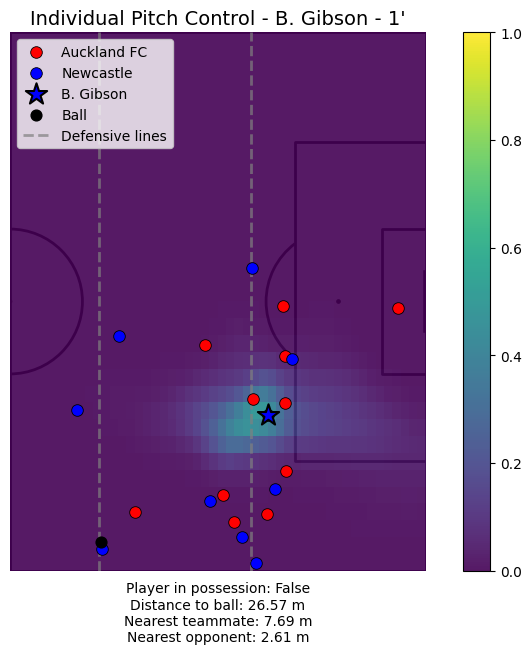

In [73]:
plot_half_pitch_individual_pitch_control(
    df=df_normed,
    frame_results=results[3],
    sigma=1.0,
    pitch_length=105,
    pitch_width=68,
    half_pitch=True,
)

In [33]:
import io

def save_npz_to_gcs(array_dict: dict, gcs_path: str):
    """Sauvegarde un .npz directement sur GCS."""
    with io.BytesIO() as buffer:
        np.savez_compressed(buffer, **array_dict)
        buffer.seek(0)
        with fsspec.open(gcs_path, "wb") as f:
            f.write(buffer.read())

In [25]:
PITCH_CONTROL_DIR = f"{BASE_GCS_PATH}/pitch_control_center_forward_low_block"

game_situation = ('team_out_of_possession_phase_type','low_block')

In [31]:
from pathlib import Path

def process_match(file_path):
    """Fonction exécutée en parallèle pour un match donné."""
    fs = gcsfs.GCSFileSystem()
    
    match_id = Path(file_path).stem
    outpath = f"{PITCH_CONTROL_DIR}/{match_id}.npz"

    if fs.exists(outpath):
        print(f"🟡 Fichier déjà existant pour le match {match_id}")
        return match_id

    print(f"🚀 Traitement du match {match_id}...")
    try:
        results = extract_all_for_position_across_match(
            match_id=match_id,
            player_position="Center Forward",
            game_situation=game_situation,
            params=params,
            resolution=1
        )
        save_npz_to_gcs({"results": results}, outpath)
        print(f"✅ Fichier sauvegardé : {outpath}")
    except Exception as e:
        print(f"❌ Erreur sur le match {match_id} : {e}")
    return match_id

In [ ]:
import concurrent.futures

parquet_files = fs.glob(f"{PROCESSED_DIR}/*.parquet")

MAX_WORKERS = 10

with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
    list(executor.map(process_match, parquet_files))

/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your appl

🚀 Traitement du match 2013725...🚀 Traitement du match 1886347...

🚀 Traitement du match 1899585...
🚀 Traitement du match 1996435...


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


🚀 Traitement du match 2006229...


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your appl

🚀 Traitement du match 1953632...


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


🚀 Traitement du match 2017461...🚀 Traitement du match 2015213...



/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


🚀 Traitement du match 1925299...


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


🚀 Traitement du match 2011166...


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)



✅ Traitement terminé : 145 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Match 1925299:  39%|███▉      | 115/294 [06:50<11:29,  3.85s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/1953632.npz



✅ Traitement terminé : 129 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Match 2017461:  61%|██████    | 129/212 [07:46<04:56,  3.58s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/2015213.npz



✅ Traitement terminé : 212 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Match 1899585:  55%|█████▌    | 142/258 [08:33<06:50,  3.54s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/2017461.npz



✅ Traitement terminé : 154 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Match 2011166:  87%|████████▋ | 155/179 [09:16<01:25,  3.57s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/2013725.npz



✅ Traitement terminé : 179 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Match 1899585:  67%|██████▋   | 172/258 [10:21<04:55,  3.43s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/2011166.npz



✅ Traitement terminé : 197 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Match 1996435:  63%|██████▎   | 179/282 [10:56<06:05,  3.55s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/2006229.npz



✅ Traitement terminé : 210 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Match 1899585:  73%|███████▎  | 189/258 [11:22<04:03,  3.53s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/1886347.npz



✅ Traitement terminé : 282 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/1996435.npz



✅ Traitement terminé : 258 frames analysées au total.


/opt/conda/envs/pitch-control/lib/python3.12/site-packages/google/auth/_default.py:108: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
Match 1925299:  82%|████████▏ | 242/294 [14:23<02:59,  3.46s/it]

✅ Fichier sauvegardé : gs://arthur_tmp/analytics_cup/pitch_control_center_forward_low_block/1899585.npz


Match 1925299:  97%|█████████▋| 285/294 [16:52<00:31,  3.55s/it]

# CLUSTERING

In [20]:
def prepare_clustering_features():
    """
    Transforme la liste de dictionnaires en matrice de features pour le clustering.
    Lit les informations contextuelles (player, équipe, minute, etc.)
    directement depuis le fichier POSSESSION_DIR/<match_id>.parquet.

    Les frames contenant des NaN dans 'player_position', 
    'distance_to_nearest_teammate' ou 'distance_to_nearest_opponent' 
    sont exclues des résultats.

    Colonnes ajoutées dans meta :
        - match_id
        - player_id
        - player_name
        - player_team
        - opponent_team
        - minute
    """

    fs = gcsfs.GCSFileSystem()
    feature_vectors = []
    meta_info = []
    frames_inputs = []

    pitch_control_files = fs.glob(f"{PITCH_CONTROL_DIR}/*.npz")
    if not pitch_control_files:
        print(f"⚠️ Aucun fichier trouvé dans {PITCH_CONTROL_DIR}")
        return None, None, None

    for gcs_path in tqdm(sorted(pitch_control_files)):
        match_id = gcs_path.split("/")[-1].replace(".npz", "")

        # --- Lecture du fichier .npz ---
        try:
            with fs.open(gcs_path, "rb") as f:
                data = np.load(f, allow_pickle=True)
                results = data["results"].tolist()
        except Exception as e:
            print(f"⚠️ Erreur lecture {gcs_path} : {e}")
            continue

        if not results:
            continue

        # --- Lecture du fichier POSSESSION correspondant ---
        possession_path = f"{PROCESSED_DIR}/{match_id}.parquet"
        try:
            with fs.open(possession_path, "rb") as fp:
                possession_df = pd.read_parquet(fp)
        except Exception as e:
            print(f"⚠️ Impossible de lire {possession_path} : {e}")
            possession_df = None

        # --- Préparer les noms d'équipes (pour déduction adversaire) ---
        all_teams = (
            possession_df["team_name"].unique().tolist()
            if possession_df is not None and "team_name" in possession_df.columns
            else []
        )

        # --- Itération sur les résultats valides ---
        for item in results:
            # Exclusion si NaN critiques
            player_position = item.get("player_position", (np.nan, np.nan))
            if (
                np.isnan(player_position[0]) or np.isnan(player_position[1]) or
                np.isnan(item.get("distance_to_nearest_teammate", np.nan)) or
                np.isnan(item.get("distance_to_nearest_opponent", np.nan))
            ):
                continue  # on ignore cette frame

            player_id = item.get("player_id")
            frame = item.get("frame")

            # (1) Flatten de la carte de Pitch Control
            pitch_flat = item["pitch_control_map"].flatten()
            
            # remove outliers
            #count_gt_0 = np.sum(pitch_flat > 0)
            count_gt_05 = np.sum(pitch_flat > 0.5)
            #if count_gt_0 > 750 or count_gt_05 > 70:
            if count_gt_05 > 70:
                continue

            # (2) Features contextuelles
            defensive_lines = np.array(item["defensive_lines"], dtype=float)
            defensive_lines = np.pad(
                defensive_lines, (0, 3 - len(defensive_lines)),
                mode='constant', constant_values=np.nan
            )

            ball_x, ball_y = item["ball_position"]
            in_possession = 1.0 if item["in_possession"] else 0.0

            context_features = np.array([
                *defensive_lines,
                ball_x,
                ball_y,
                in_possession,
                item["distance_to_ball"],
                item["distance_to_nearest_teammate"],
                item["distance_to_nearest_opponent"]
            ], dtype=float)

            full_vector = np.concatenate([pitch_flat, context_features])
            feature_vectors.append(full_vector)
            frames_inputs.append(item)

            # (3) Récupération des infos depuis le parquet possession
            if possession_df is not None:
                row = possession_df[
                    (possession_df["frame"] == frame) &
                    (possession_df["player_id"] == player_id)
                ]
                if not row.empty:
                    row = row.iloc[0]
                    player_name = row.get("player_short_name", None)
                    player_team = row.get("team_name", None)
                    #minute = None
                    #time_val = row.get("time", None)
                    #if isinstance(time_val, str) and len(time_val) >= 5:
                    #    try:
                    #        minute = int(time_val.split(":")[1])
                    #    except Exception:
                    #        minute = None
                    time_s = row.get("time_s", None)
                    minute = int(time_s // 60)


                    # Déduire l’adversaire
                    opponent_team = None
                    if all_teams and player_team in all_teams:
                        opponent_team = [t for t in all_teams if t != player_team]
                        opponent_team = opponent_team[0] if opponent_team else None
                else:
                    player_name = None
                    player_team = None
                    opponent_team = None
                    minute = None
            else:
                player_name = None
                player_team = None
                opponent_team = None
                minute = None

            # (4) Ajouter au meta_info
            meta_info.append({
                "match_id": match_id,
                "frame": frame,
                "player_id": player_id,
                "player_position_role": item.get("player_position_role", None),
                "player_name": player_name,
                "player_team": player_team,
                "opponent_team": opponent_team,
                "minute": minute
            })

    if not feature_vectors:
        print("⚠️ Aucun vecteur de features généré (fichiers vides ?)")
        return None, None, None

    # --- Matrice finale des features ---
    X = np.vstack(feature_vectors)

    # --- Gestion des NaN restants (remplacés par moyenne colonne) ---
    nan_mask = np.isnan(X)
    if np.any(nan_mask):
        col_means = np.nanmean(X, axis=0)
        inds = np.where(nan_mask)
        X[inds] = np.take(col_means, inds[1])

    meta = pd.DataFrame(meta_info)
    return X, meta, frames_inputs

In [21]:
%%time

X, meta, frames_inputs = prepare_clustering_features()

100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

CPU times: user 2.68 s, sys: 293 ms, total: 2.97 s
Wall time: 20.8 s


In [24]:
X.shape

(1522, 1609)

In [26]:
meta

,match_id,frame,player_id,player_position_role,player_name,player_team,opponent_team,minute,cluster,cluster_gathered
0,1886347,301,38673,Center Forward,G. May,Auckland FC,Newcastle United Jets FC,0,1,1
1,1886347,350,38673,Center Forward,G. May,Auckland FC,Newcastle United Jets FC,0,0,0
2,1886347,1102,966120,Center Forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,0,0
3,1886347,1122,966120,Center Forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,3,1
4,1886347,1204,966120,Center Forward,B. Gibson,Newcastle United Jets FC,Auckland FC,1,1,1
...,...,...,...,...,...,...,...,...,...,...
1517,2017461,52985,38673,Center Forward,G. May,Auckland FC,Melbourne Victory Football Club,22,1,1
1518,2017461,53465,38673,Center Forward,G. May,Auckland FC,Melbourne Victory Football Club,22,0,0
1519,2017461,53474,38673,Center Forward,G. May,Auckland FC,Melbourne Victory Football Club,23,1,1
1520,2017461,53503,38673,Center Forward,G. May,Auckland FC,Melbourne Victory Football Club,23,1,1


In [11]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import joblib

def load_pipeline_gcs(
    fs: gcsfs.GCSFileSystem,
    gcs_path: str,
) -> Pipeline:
    with fs.open(gcs_path, "rb") as f:
        return joblib.load(f)

In [12]:
PIPELINE_PATH = f"{CLUSTERING_DIR}/clustering_pipeline.joblib"

pipeline = load_pipeline_gcs(fs, PIPELINE_PATH)

In [15]:
labels = pipeline.predict(X)

In [16]:
labels

array([1, 0, 0, ..., 1, 1, 0], dtype=int32)

In [25]:
meta["cluster"] = labels

cluster_mapping = {
    0:0,
    1:1,
    2:2,
    3:1,
    4:3,
    5:2,
    6:4,
    7:4,
    8:3,
    9:2,
    10:2
}

meta['cluster_gathered'] = meta['cluster'].map(cluster_mapping)

# SOCCERMAP PREDICTIONS

In [27]:
PITCH_LENGTH = 105
PITCH_WIDTH  = 68
GOAL_CENTER  = np.array([105.0, 34.0])
GOAL_Y_TOP    = 34 + 7.32/2
GOAL_Y_BOTTOM = 34 - 7.32/2
GOAL_X        = 105.0


# ------------------------------------------------------------
# Grid
# ------------------------------------------------------------
def create_pitch_grid(dim=(68,105)):
    H, W = dim
    y = np.linspace(0, PITCH_WIDTH, H)
    x = np.linspace(0, PITCH_LENGTH, W)
    return np.meshgrid(x, y)   # shape (H,W)

# ------------------------------------------------------------
# 6 SPARSE CHANNELS: (att: loc,vx,vy) + (def: loc,vx,vy)
# ------------------------------------------------------------
def make_sparse_player_channels(df_frame, attacking_team, defending_team, dim=(68,105)):
    H, W = dim
    att = np.zeros((3, H, W), dtype=np.float32)
    deff = np.zeros((3, H, W), dtype=np.float32)

    for _, r in df_frame.iterrows():
        if r["is_ball"]: 
            continue

        x = int(np.clip(round(r["x_rescaled"] / PITCH_LENGTH * W), 0, W - 1))
        y = int(np.clip(round(r["y_rescaled"] / PITCH_WIDTH  * H), 0, H - 1))

        vx, vy = r.get("vx_mps", 0.0), r.get("vy_mps", 0.0)

        if r["team_short"] == attacking_team:
            att[0, y, x] = 1
            att[1, y, x] = vx
            att[2, y, x] = vy
        else:
            deff[0, y, x] = 1
            deff[1, y, x] = vx
            deff[2, y, x] = vy

    return att, deff

# ------------------------------------------------------------
# 2 DENSE CHANNELS: distances
# ------------------------------------------------------------
def make_distance_maps(ball_pos, dim=(68,105)):
    X, Y = create_pitch_grid(dim)
    dist_ball = np.sqrt((X - ball_pos[0])**2 + (Y - ball_pos[1])**2)
    dist_goal = np.sqrt((X - GOAL_CENTER[0])**2 + (Y - GOAL_CENTER[1])**2)
    return dist_ball.astype(np.float32), dist_goal.astype(np.float32)

# ------------------------------------------------------------
# 3 DENSE CHANNELS: angle maps (sin,cos,raw)
# ------------------------------------------------------------
def make_angle_maps(dim=(68,105)):
    H, W = dim
    X, Y = create_pitch_grid(dim)  # shape (H,W)

    # Vectors from each grid point to the top/bottom posts
    top_dx = GOAL_X - X
    top_dy = GOAL_Y_TOP - Y
    bot_dx = GOAL_X - X
    bot_dy = GOAL_Y_BOTTOM - Y

    top_angle = np.arctan2(top_dy, top_dx)
    bot_angle = np.arctan2(bot_dy, bot_dx)

    angle_open = np.abs(top_angle - bot_angle)
    angle_open = np.clip(angle_open, 0, np.pi)

    sin_map = np.sin(angle_open)
    cos_map = np.cos(angle_open)

    return sin_map.astype(np.float32), cos_map.astype(np.float32), angle_open.astype(np.float32)

# ------------------------------------------------------------
# 2 SPARSE CHANNELS: sin/cos(angle between ball-carrier
#                     vel and each teammate’s vel)
# ------------------------------------------------------------
def make_velocity_angle_channels(df_frame, ball_carrier_id, dim=(68,105)):
    H, W = dim
    sin_ch = np.zeros((H, W), dtype=np.float32)
    cos_ch = np.zeros((H, W), dtype=np.float32)

    carrier = df_frame[df_frame.player_id == ball_carrier_id]
    if carrier.empty:
        return sin_ch, cos_ch

    carrier = carrier.iloc[0]
    vx_c, vy_c = carrier.get("vx_mps", 0), carrier.get("vy_mps", 0)
    norm_c = np.hypot(vx_c, vy_c)

    if norm_c < 1e-6:
        return sin_ch, cos_ch

    for _, r in df_frame.iterrows():
        if r["is_ball"] or r["player_id"] == ball_carrier_id:
            continue

        x = int(np.clip(round(r["x_rescaled"] / PITCH_LENGTH * W), 0, W - 1))
        y = int(np.clip(round(r["y_rescaled"] / PITCH_WIDTH  * H), 0, H - 1))

        vx, vy = r.get("vx_mps", 0), r.get("vy_mps", 0)
        norm_t = np.hypot(vx, vy)
        if norm_t < 1e-6:
            continue

        dot = (vx*vx_c + vy*vy_c) / (norm_c * norm_t)
        dot = np.clip(dot, -1, 1)
        ang = np.arccos(dot)

        sin_ch[y, x] = np.sin(ang)
        cos_ch[y, x] = np.cos(ang)

    return sin_ch, cos_ch


# ------------------------------------------------------------
# FULL 13-CHANNEL MAP FOR ONE FRAME
# ------------------------------------------------------------
def generate_soccer_map(df_frame, attacking_team, defending_team, ball_pos, ball_carrier_id):
    att, deff = make_sparse_player_channels(df_frame, attacking_team, defending_team)
    dist_ball, dist_goal = make_distance_maps(ball_pos)
    sin_g, cos_g, ang_g = make_angle_maps()
    sin_v, cos_v = make_velocity_angle_channels(df_frame, ball_carrier_id)

    tensor = np.stack([
        *att, *deff,
        dist_ball, dist_goal,
        sin_g, cos_g, ang_g,
        sin_v, cos_v
    ], axis=0)  # (13, 68, 105)

    return tensor.astype(np.float32)

class ToSoccerMapPassSuccessTensorFromFrame:
    """
    Convert an entire frame (23 rows: 22 players + ball) into a 13-channel SoccerMap.
    Output: (13, H, W), mask (1, H, W), target scalar.
    """

    def __init__(self, dim=(68, 105)):
        self.H, self.W = dim   # grid resolution

    def _scale_coords(self, x, y):
        """Scale real pitch coords to grid indices"""
        xi = np.clip(np.round(x / PITCH_LENGTH * self.W), 0, self.W - 1).astype(int)
        yi = np.clip(np.round(y / PITCH_WIDTH  * self.H), 0, self.H - 1).astype(int)
        return xi, yi

    def __call__(self, df_frame):
        """
        df_frame = sous-dataframe des 23 rows d’un frame.
        """
        # ---- Extract infos identical for all rows ----
        start_x = df_frame["x_start_rescaled"].iloc[0]
        start_y = df_frame["y_start_rescaled"].iloc[0]
        end_x   = df_frame["x_end_rescaled"].iloc[0]
        end_y   = df_frame["y_end_rescaled"].iloc[0]

        target = float(df_frame["label"].iloc[0])
        ball_row = df_frame[df_frame["is_ball"]].iloc[0]
        ball_pos = np.array([ball_row["x_rescaled"], ball_row["y_rescaled"]])

        ball_carrier_id = df_frame["player_in_possession_id"].iloc[0]

        # Teams
        attacking = df_frame[df_frame["player_id"] == ball_carrier_id]["team_short"].iloc[0]
        defending = df_frame[df_frame["team_short"] != attacking]["team_short"].unique()[0]

        # ---- Build channels ----
        att_ch, def_ch = make_sparse_player_channels(df_frame, attacking, defending, dim=(self.H, self.W))
        dist_ball, dist_goal = make_distance_maps(ball_pos, dim=(self.H, self.W))
        sin_goal, cos_goal, angle_goal = make_angle_maps(dim=(self.H, self.W))
        sin_vel, cos_vel = make_velocity_angle_channels(df_frame, ball_carrier_id, dim=(self.H, self.W))

        tensor = np.stack([
            *att_ch,
            *def_ch,
            dist_ball, dist_goal,
            sin_goal, cos_goal, angle_goal,
            sin_vel, cos_vel
        ], axis=0)  # (13, H, W)

        # ---- mask: 1 at end location ----
        xe, ye = self._scale_coords(end_x, end_y)
        mask = np.zeros((1, self.H, self.W), dtype=np.float32)
        mask[0, ye, xe] = 1.0

        return (
            torch.tensor(tensor, dtype=torch.float32),
            torch.tensor(mask, dtype=torch.float32),
            torch.tensor([target], dtype=torch.float32),
        )

In [28]:
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
import tempfile

class SoccerMap(nn.Module):
    def __init__(self, in_channels=13):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, padding=1),
            nn.GroupNorm(1, 32),  # remplace BatchNorm2d
            nn.ReLU(),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.GroupNorm(1, 64),
            nn.ReLU()
        )
        self.head = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x = torch.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
        x = torch.clamp(x, -1.0, 1.0)
        x = self.encoder(x)
        x = self.head(x)
        return x  # [B, 1, H, W]

class PytorchSoccerMapModel(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        self.save_hyperparameters() # saves lr=1e-4 automatically, so it’s logged and checkpointed.

        # --- Core SoccerMap CNN ---
        self.model = SoccerMap(in_channels=13)

        # --- Loss & Metrics ---
        self.criterion = nn.BCEWithLogitsLoss() # The main training objective — compares predictions vs. true labels (0 or 1). It’s a binary cross-entropy loss that expects raw outputs (logits) from the model.
        self.train_acc = torchmetrics.classification.BinaryAccuracy() # How often the model’s prediction is correct (above or below 0.5).
        self.train_auc = torchmetrics.classification.BinaryAUROC() # Measures how well the model ranks positives above negatives — more robust than accuracy for imbalanced data.
        self.val_acc = torchmetrics.classification.BinaryAccuracy()
        self.val_auc = torchmetrics.classification.BinaryAUROC()
        
    def on_train_start(self):
        print(f"🚀 Training on device: {self.device}")
        # Si tu veux logguer la mémoire GPU :
        if self.device.type == "cuda":
            print(f"🔋 GPU memory allocated: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")

    def forward(self, x):
        """Forward pass through CNN to get full surface logits. “To make a prediction, pass the input x through the CNN.”"""
        return self.model(x)  # [B, 1, 68, 105]

    def shared_step(self, batch, stage="train"):
        x, mask, y = batch
        logits = self(x)  # [B, 1, 68, 105] runs the CNN to produce the surface logits (raw values before sigmoid).

        # --- Apply mask to reduce spatial logits to one scalar per sample ---
        masked_logits = (logits * mask).sum(dim=(2, 3))  # [B, 1]
        """extracts only the predicted value at the pass destination cell.
        The rest of the pitch is ignored (set to zero).
        The sum effectively collapses the spatial surface into a single scalar prediction per sample.
        So now you’ve gone from [B, 1, 68, 105] → [B, 1]."""

        # --- Compute loss ---
        loss = self.criterion(masked_logits, y)

        # --- Compute metrics ---
        probs = torch.sigmoid(masked_logits) # sigmoid converts raw numbers into probabilities (0–1 range).
        acc = self.train_acc(probs, y.int()) if stage == "train" else self.val_acc(probs, y.int())
        auc = self.train_auc(probs, y.int()) if stage == "train" else self.val_auc(probs, y.int())

        # --- Logging ---
        self.log(f"{stage}/loss", loss, prog_bar=True, on_epoch=True)
        self.log(f"{stage}/acc", acc, prog_bar=True, on_epoch=True)
        self.log(f"{stage}/auc", auc, prog_bar=True, on_epoch=True)
        """Lightning handles logging automatically — these values will appear in your progress bar and epoch summaries."""

        return loss

    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, stage="val")
    
    def on_train_epoch_end(self):
        loss = self.trainer.callback_metrics.get("train/loss_epoch")
        acc = self.trainer.callback_metrics.get("train/acc_epoch")
        auc = self.trainer.callback_metrics.get("train/auc_epoch")
        print(f"🧠 Epoch {self.current_epoch} — TRAIN | loss: {loss:.4f}, acc: {acc:.4f}, auc: {auc:.4f}")

    def on_validation_epoch_end(self):
        loss = self.trainer.callback_metrics.get("val/loss")
        acc = self.trainer.callback_metrics.get("val/acc")
        auc = self.trainer.callback_metrics.get("val/auc")
        print(f"🎯 Epoch {self.current_epoch} — VAL | loss: {loss:.4f}, acc: {acc:.4f}, auc: {auc:.4f}")


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr) # The optimizer updates all model parameters based on gradients from the loss function.

In [29]:
def load_checkpoint_from_gcs(gcs_path: str, model_class: pl.LightningModule):
    """
    Télécharge un checkpoint depuis GCS vers un fichier temporaire
    puis charge le modèle Lightning.
    
    Parameters
    ----------
    gcs_path : str
        Ex: "gs://arthur_tmp/soccermap_model/best.ckpt"
    model_class : LightningModule
        La classe du modèle (ex: PytorchSoccerMapModel)

    Returns
    -------
    model : LightningModule
    """

    # 1) On crée un fichier temporaire local
    with tempfile.NamedTemporaryFile(suffix=".ckpt", delete=True) as tmp:

        # 2) Téléchargement depuis GCS vers ce fichier temp
        fs = fsspec.filesystem("gs")
        with fs.open(gcs_path, "rb") as remote_file:
            tmp.write(remote_file.read())
            tmp.flush()

        # 3) Chargement du modèle PL
        model = model_class.load_from_checkpoint(tmp.name)
        model.eval()
        return model

In [30]:
BASE_GCS_PATH_OLD = f"gs://{BUCKET_NAME}"
SOCCERMAP_MODELS_DIR = f"{BASE_GCS_PATH_OLD}/soccermap_model"

In [31]:
best_ckpt_xpass_path = f"{SOCCERMAP_MODELS_DIR}/best_xpass.ckpt"
best_ckpt_xthreat_path = f"{SOCCERMAP_MODELS_DIR}/best_xthreat.ckpt"

model_xpass = load_checkpoint_from_gcs(best_ckpt_xpass_path, PytorchSoccerMapModel)
model_xthreat = load_checkpoint_from_gcs(best_ckpt_xthreat_path, PytorchSoccerMapModel)

In [ ]:
# On adapte les processed dataframes pour pouvoir leur appliquer le Tensorizer (colonne 'label')